# Logistic Regression / GLM and Regularization IRLS

### Arjoon Srikanth

In [495]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs


In [634]:
from matplotlib import pyplot as plt

In [249]:
from sklearn.model_selection import train_test_split

glm = GLM()

X = pd.DataFrame(load_digits(return_X_y = True)[0])

y = pd.DataFrame(load_digits(return_X_y = True)[1])

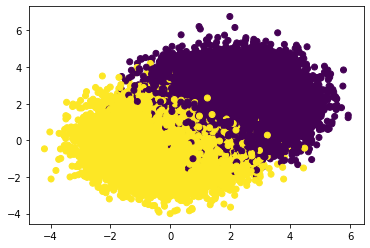

In [700]:
centers = [[2, 2], [0, 0]]
X_b, y_b = make_blobs(n_samples=100000, centers=centers, random_state=40)

X_b, y_b


plt.scatter(X_b[:, 0], X_b[:, 1], c = y_b)

In [612]:
class GLM(object):
    
    def __init__(self, X = np.array([]), y = np.array([]), name = 'GLM'):
        
        self.name = name
        self.X = np.vstack([np.ones((X.shape[0], )), np.array(X).T]).T
        self.y = np.array(y)
        self.beta = np.zeros(self.X.shape[1])
    
    def train(self, output = False):
        
        
        beta_ = np.inf
        count = 0
        
        while max(abs(self.beta - beta_)) > float('1e-6'):
            pi = self._probabilities() # ndarray
            var = self._var() # ndarray of variances
            VX = self.X*(var.reshape(-1, 1))
            XVX = np.dot(self.X.T, VX)
            VXbeta = np.dot(VX, self.beta)
            beta_ = self.beta
            self.beta = np.linalg.solve(XVX, np.dot(self.X.T, VXbeta + self.y - pi))
            count += 1;
            
            
        return self.beta
     
    def predict(self, X_test):
        
        X_test = np.vstack([np.ones((X_test.shape[0], )), np.array(X_test).T]).T

        return self._invLink(np.matmul(X_test, self.beta))
    
    def _invLink(self):
        pass
    
    def _var(self):
        pass
    
    def _probabilities(self):
        Eta = np.matmul(self.X, self.beta)
        
        return self._invLink(Eta)

In [613]:

class LogisticRegression(GLM):
    
    
    def _invLink(self, eta):
        
        return 1 / (1 + np.exp(-eta))
    
    def _var(self):
        prob = self._probabilities()
        return prob * (1 - prob)
    

class PoissonRegression(GLM):
    
    
    def _invLink(self, eta):
        
        return np.exp(eta)
    
    def _var(self):
        
        return  self._probabilities()

## Testing Models Logistic Regression

In [651]:
from sklearn.model_selection import train_test_split

In [701]:
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size = 0.25)

In [702]:
lr = LogisticRegression(X_train, y_train)

In [703]:
w  = lr.train()

In [704]:
w

array([ 4.02387942, -1.99522511, -2.01701477])

In [674]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [705]:
roc_auc_score(y_test, lr.predict(X_test))

0.976401724224276

In [706]:
confusion_matrix(y_b, lr.predict(X_b).round())

array([[46039,  3961],
       [ 3845, 46155]], dtype=int64)

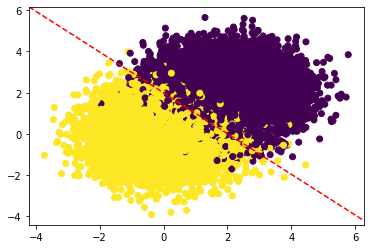

In [707]:
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test)

ax = plt.gca()

ax.autoscale(False)

x_vals = np.array(ax.get_xlim())
y_vals = -(x_vals * w[1] + w[0]) / w[2]

plt.plot(x_vals, y_vals, '--', c = "red")


The model creates a maximum likelihood estimate for the weight vector; we have plotted the line of best fit here. Next comes testing the Poisson Regressor.

## Testing Models Poisson Regression

In [757]:
df = pd.read_csv('poisson_sim.csv')

In [758]:
df.head()

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40


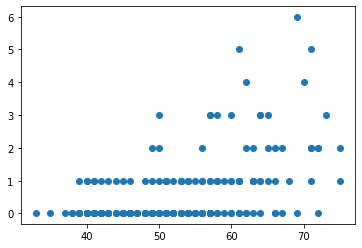

In [781]:
plt.scatter(df['math'], df['num_awards'])

In [740]:
df['Frequency'] = df['ClaimNb'] / df['Exposure']

In [741]:
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,10.000000
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,1.298701
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,1.333333
3,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,11.111111
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,1.190476


In [769]:
ps = PoissonRegression(df['math'], df['num_awards'])

In [770]:
w = ps.train()
w

array([-5.33353206,  0.0861656 ])

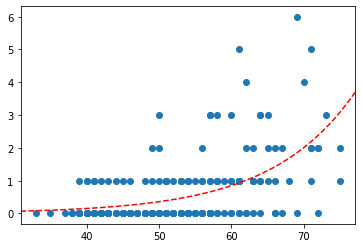

In [780]:
plt.scatter(df['math'], df['num_awards'])

ax = plt.gca()

ax.autoscale(False)

x_vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 500)
y_vals = np.exp(x_vals * w[1] + w[0])

plt.plot(x_vals, y_vals, '--', c = "red")

We find $\hat\beta_0$ value equal to $-5.33$ and $\hat\beta_1$ equal to $0.086156$ in the Poisson regression. We should compare this value to the expected value from the R GLM package.

An R analysis of the dataset gives an expected $\hat\beta_0$ of $-5.3353$ and a $\hat\beta_1$ of $0.08617$, exactly matching our solver.

    Coefficients:
    (Intercept)         math
    -5.33353      0.08617

    Degrees of Freedom: 199 Total (i.e. Null);  198 Residual
    Null Deviance:      287.7
    Residual Deviance: 204  AIC: 384.1``

We'll do another check using all three variables:

In [782]:
ps_1 = PoissonRegression(df[['math', 'prog']], df['num_awards'])

In [783]:
ps_1.train()

array([-5.57805691,  0.086121  ,  0.12327256])

We find our weights to be $\hat\beta_0 = -5.578$, $\hat\beta_1 = 0.08612$, and $\hat\beta_2 = 0.12327256$

Our R output for the model gives us:

    Coefficients:
    (Intercept)         math         prog
       -5.57806      0.08612      0.12327

    Degrees of Freedom: 199 Total (i.e. Null);  197 Residual
    Null Deviance:      287.7
    Residual Deviance: 203.5        AIC: 385.

Exactly equivalent. 

Our iteratively reweighted least squares solution works!

Next, we will be adding regularization capabilities on both our GLMs to test generalizability.